# Imports

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # surpress warning and info messages
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import L2 as l2
import tensorflow as tf
from os.path import *
import pandas as pd
import numpy as np
import json
import glob
import sys

sys.path.append('../Model')
sys.path.append('../DataGenerators')
from fusion_data_generator import FusionDataGenerator

# Function Definitions

In [ ]:
def get_running_times(root):
    with open(f'{root}POWER/metadata.json', 'r') as f: # the running time of both datasets are identical
        metadata = json.load(f)
        max =  metadata['max_running_time']
        min =  metadata['min_running_time']
        return max,min

# builds a dataframe with the path and class of each sample
def get_samples(root):
    samples_df = pd.DataFrame(columns=["EM_path", "POWER_path","class", "numeric_class"])
    power_samples_path = []
    em_samples_path = []
    samples_class = []

    for filename in glob.iglob(f'{root}POWER/**/*.npy', recursive=True):
        clas = basename(dirname(filename)) # folder name is the name of the class
        power_sample_path = filename
        power_samples_path.append(power_sample_path)
        em_samples_path.append(power_sample_path.replace("POWER","EM"))
        samples_class.append(clas)

    samples_df["POWER_path"] = power_samples_path
    samples_df["EM_path"] = em_samples_path
    samples_df["class"] = samples_class

    unique_classes = samples_df["class"].copy().drop_duplicates().sort_values(ignore_index=True)
    samples_df['numeric_class'] = samples_df['class'].apply(lambda class_name: unique_classes[unique_classes == class_name].index[0])
    
    return samples_df, unique_classes


# Testing

In [ ]:
accuracies = []
dataset_path = "../testset/"

max_running_time, min_running_time  = get_running_times(dataset_path)
samples_df, classes_df = get_samples(dataset_path)

for noise_strength in range(0,21):
    test_generator = FusionDataGenerator(samples_df, mode='intermediate', n_classes=24, max_running_time=max_running_time, min_running_time=min_running_time, sampling_rate_power=1000000000, sampling_rate_em=56000000, overlapping_percentage=0.6, em_noise_sigma=noise_strength, power_noise_sigma=noise_strength)

    model = tf.keras.models.load_model(f"../trained_models/intermediate_integration/em_{noise_strength}_power_{noise_strength}")
    
    y_test_pred_proba = model.predict(test_generator, verbose=1)

    y_pred = np.argmax(y_test_pred_proba, axis=1)
    y_true = test_generator.y_true

    accuracy = sum(y_pred == y_true) / len(y_true)
    accuracies.append(accuracy)
    print(f"Noise: {noise_strength}, Accuracy: {accuracy}")

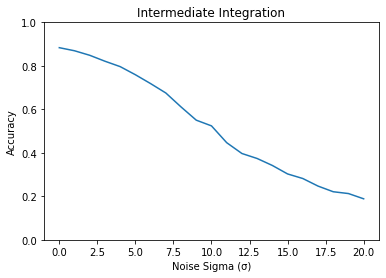

In [4]:
plt.plot(range(0,21), accuracies)
plt.title("Intermediate Integration")
plt.xlabel(f'Noise Sigma (\u03c3)')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.show()